<a href="https://colab.research.google.com/github/grohan1130/lip-reader-cv/blob/main/lip_reader_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install dependencies
!pip install tensorflow opencv-python matplotlib gdown imageio


In [2]:
# Import necessary libraries
import os
import cv2
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import imageio
from typing import List

In [3]:
# Enable GPU support in TensorFlow
tf.config.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

1. Data Loading Functions

In [4]:
import gdown

In [5]:

data_url = 'https://drive.google.com/uc?id=1GZ42ksPjkisUQJM6Jrt53h8Ew8WBkn6J'
output = 'data.zip'
gdown.download(data_url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1GZ42ksPjkisUQJM6Jrt53h8Ew8WBkn6J
From (redirected): https://drive.google.com/uc?id=1GZ42ksPjkisUQJM6Jrt53h8Ew8WBkn6J&confirm=t&uuid=89b77727-5018-4e37-9fc3-8659f3470dc5
To: /content/data.zip
100%|██████████| 423M/423M [00:12<00:00, 33.9MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [6]:
# verifying directory structure
!ls

data  data.zip	drive  sample_data


In [7]:
# Function to load video
def load_video(path: str) -> tf.Tensor:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if not ret:
            break
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()
    frames = tf.stack(frames, axis=0)
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
# vocabulary setup
vocabulary = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
vocabulary

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocabulary, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), invert=True, oov_token=""
)
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size: {char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size: 40)


In [10]:
# Function to load alignments
def load_alignments(path: str) -> tf.Tensor:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Alignment file not found: {path}")
    with open(path, "r") as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if len(line) > 2 and line[2] != 'sil':
            tokens.extend([' ', line[2]])
    tokens = tf.strings.unicode_split(tokens, input_encoding="UTF-8")
    tokens = tf.reshape(tokens, (-1,))
    return char_to_num(tokens)[1:]

In [11]:
# Function to load data (video + alignments)
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = os.path.basename(path).split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')

    #print(f"Processing video: {video_path}")
    #print(f"Processing alignment: {alignment_path}")

    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments


In [12]:
# Test load_data function
test_path = './data/s1/bbal6n.mpg'
frames, alignments = load_data(tf.convert_to_tensor(test_path))

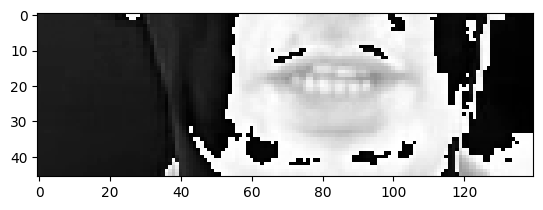

In [13]:
# Display a sample frame
plt.imshow(frames[40].numpy().squeeze(), cmap='gray')
plt.show()

In [14]:
# Decode alignments to text
alignment_text = tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])
print(f"Alignment text: {alignment_text.numpy().decode('utf-8')}")

Alignment text: bin blue at l six now


In [15]:
# Mappable function for TensorFlow Dataset
def mappable_function(path: tf.Tensor):
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

2. Pipeline

In [16]:
"""2. Pipeline"""

# Dataset pipeline
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)

# Adjust `padded_shapes` to match the model's input shape
data = data.padded_batch(
    2,  # Batch size
    padded_shapes=(
        [75, 46, 140, 1],  # Video frames: time_steps, height, width, channels
        [40]  # Alignments: max label length
    )
)
data = data.prefetch(tf.data.AUTOTUNE).cache()


In [17]:
# Split dataset into train and test sets
train = data.take(450)
test = data.skip(450)

In [18]:
# Test the pipeline
frames, alignments = next(iter(data.as_numpy_iterator()))
print("Sample pipeline output:")
print(f"Frames shape: {frames.shape}")
print(f"Alignments shape: {alignments.shape}")

Sample pipeline output:
Frames shape: (2, 75, 46, 140, 1)
Alignments shape: (2, 40)


In [19]:
len(frames)


2

In [20]:
sample = data.as_numpy_iterator()


In [21]:
val = sample.next(); val[0]


array([[[[[ 1.3465565 ],
          [ 1.3465565 ],
          [ 1.3465565 ],
          ...,
          [ 9.464369  ],
          [ 0.        ],
          [ 9.34895   ]],

         [[ 1.3465565 ],
          [ 1.3465565 ],
          [ 1.3465565 ],
          ...,
          [ 8.964219  ],
          [ 9.0796385 ],
          [ 8.733381  ]],

         [[ 1.2696105 ],
          [ 1.2696105 ],
          [ 1.2696105 ],
          ...,
          [ 9.3874235 ],
          [ 9.579788  ],
          [ 9.579788  ]],

         ...,

         [[ 0.9233531 ],
          [ 0.9233531 ],
          [ 0.9233531 ],
          ...,
          [ 9.733681  ],
          [ 9.695208  ],
          [ 9.695208  ]],

         [[ 0.9233531 ],
          [ 0.9233531 ],
          [ 0.9233531 ],
          ...,
          [ 9.618261  ],
          [ 9.618261  ],
          [ 9.618261  ]],

         [[ 0.9233531 ],
          [ 0.9233531 ],
          [ 0.9233531 ],
          ...,
          [ 9.618261  ],
          [ 9.618261  ],
          

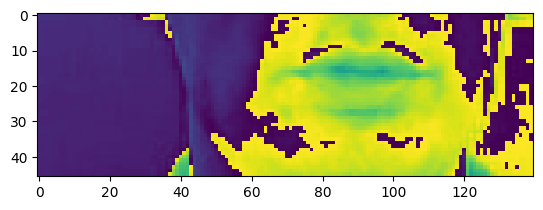

In [22]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [23]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place red with q four please'>

3. Neural Network Design

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [27]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [28]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 75, 46, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 75, 46, 140, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 75, 23, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 75, 23, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 75, 23, 70, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 75, 11, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 75, 11, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 75, 11, 35, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 75, 5, 17, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 75, 6375)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 75, 256)             │       6,660,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
5*17*75

6375

In [31]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [32]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'222222222222222222222222222222222222222222222222222222222222222222222222222'>

In [33]:
model.input_shape


(None, 75, 46, 140, 1)

In [34]:
model.output_shape


(None, 75, 41)

4. Setting Up Operations and Training

In [35]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [36]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    # Set input and label lengths for each batch
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # Compute CTC loss
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [37]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(
            yhat, input_length=tf.fill([len(yhat)], tf.shape(yhat)[1]), greedy=True
        )[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~' * 100)

In [38]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)


In [39]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join('models', 'checkpoint.weights.h5'),
    monitor='loss',
    save_weights_only=True
)

In [40]:
schedule_callback = LearningRateScheduler(scheduler)

In [41]:
example_callback = ProduceExample(test)

In [42]:
print("GPUs available:", tf.config.list_physical_devices('GPU'))


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Train the model
model.fit(
    train,
    validation_data=test,
    epochs=10,
    callbacks=[checkpoint_callback, schedule_callback, example_callback]
)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Original: bin green with b five soon
Prediction: le 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green in b eight now
Prediction: le 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 937s 2s/step - loss: 101.1045 - val_loss: 69.7266 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Original: lay green in f two please
Prediction: la e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red in s five again
Prediction: la e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 255s 567ms/step - loss: 71.7970 - val_loss: 65.6496 - learning_rate: 1.0000e-04
Epoch 3/10
374/450 ━━━━━━━━━━━━━━━━━━━━ 40s 539ms/step - loss: 68.1391